In [431]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
using JLD2
data_home = "../TMazeDrifterDistractorESARSAControl"

"../TMazeDrifterDistractorESARSAControl"

In [432]:
pwd()

"/home/matthewmcleod/Documents/Masters/curiosity/plotting"

# Plotting

In [433]:
ic = ItemCollection(joinpath(data_home, "data"));

In [434]:
swept_params = diff(ic)


Dict{String,Array} with 6 entries:
  "demon_learner"     => ["Q", "SR"]
  "demon_eta"         => [0.25, 0.5, 1.0]
  "exploration_param" => [0.15, 0.3]
  "demon_opt"         => ["Auto", "Descent"]
  "seed"              => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
  "behaviour_eta"     => [0.25, 0.5]

In [435]:
function load_results(ic, logger_key; return_type = "tensor")
    num_results = length(ic)
    results = []
    for itm in ic.items
        data = FileIO.load(joinpath(itm.folder_str, "results.jld2"))["results"]
        push!(results,data[logger_key])
    end
    
    if return_type == "tensor"
        return cat(results..., dims = 3)
    elseif return_type == "array"
        return results
    end
end

load_results (generic function with 1 method)

In [436]:
# After implementing, I think I saw there is a Iterators.product that does this?
function combine(dict_arr, key, vals)
    new_dict_arr = []
    for dict in dict_arr
        for val in vals
            new_dict = deepcopy(Dict(dict))
            new_dict[key] = val
            push!(new_dict_arr, new_dict)
        end
    end
    return new_dict_arr
end

function split_algo(algo_ic, swept_params)
    println(swept_params)
    dicts = [Dict()]
    for k in swept_params
        list_of_params = diff(algo_ic)[k]
        dicts = combine(dicts, k, list_of_params)
    end
    return dicts
end

split_algo (generic function with 1 method)

In [437]:
algo_divisor_keys = ["demon_opt", "demon_learner"]
# algo_divisor_keys = ["use_external_reward","demon_learner"]
algo_divisors = split_algo(ic, algo_divisor_keys)

["demon_opt", "demon_learner"]


4-element Array{Any,1}:
 Dict{Any,Any}("demon_learner" => "Q","demon_opt" => "Auto")
 Dict{Any,Any}("demon_learner" => "SR","demon_opt" => "Auto")
 Dict{Any,Any}("demon_learner" => "Q","demon_opt" => "Descent")
 Dict{Any,Any}("demon_learner" => "SR","demon_opt" => "Descent")

In [439]:
# sweep_keys = ["behaviour_alpha","demon_alpha"]
sweep_keys = ["demon_eta", "behaviour_eta", "exploration_param"]
sweep_divisors = split_algo(ic,sweep_keys)

["demon_eta", "behaviour_eta", "exploration_param"]


12-element Array{Any,1}:
 Dict{Any,Any}("demon_eta" => 0.25,"exploration_param" => 0.15,"behaviour_eta" => 0.25)
 Dict{Any,Any}("demon_eta" => 0.25,"exploration_param" => 0.3,"behaviour_eta" => 0.25)
 Dict{Any,Any}("demon_eta" => 0.25,"exploration_param" => 0.15,"behaviour_eta" => 0.5)
 Dict{Any,Any}("demon_eta" => 0.25,"exploration_param" => 0.3,"behaviour_eta" => 0.5)
 Dict{Any,Any}("demon_eta" => 0.5,"exploration_param" => 0.15,"behaviour_eta" => 0.25)
 Dict{Any,Any}("demon_eta" => 0.5,"exploration_param" => 0.3,"behaviour_eta" => 0.25)
 Dict{Any,Any}("demon_eta" => 0.5,"exploration_param" => 0.15,"behaviour_eta" => 0.5)
 Dict{Any,Any}("demon_eta" => 0.5,"exploration_param" => 0.3,"behaviour_eta" => 0.5)
 Dict{Any,Any}("demon_eta" => 1.0,"exploration_param" => 0.15,"behaviour_eta" => 0.25)
 Dict{Any,Any}("demon_eta" => 1.0,"exploration_param" => 0.3,"behaviour_eta" => 0.25)
 Dict{Any,Any}("demon_eta" => 1.0,"exploration_param" => 0.15,"behaviour_eta" => 0.5)
 Dict{Any,Any}("demon_et

In [440]:
function get_best(ic, sweep_params, metric)
    splits = split_algo(ic,sweep_params)
    errors = ones(length(splits)) * Inf
    for (ind, split) in enumerate(splits)
        res = load_results(search(ic, split), metric)
        error = mean(res)
        errors[ind] = error
    end
    low_err, low_err_ind = findmin(errors)
    println(errors)
    
    return search(ic, splits[low_err_ind])
end

get_best (generic function with 1 method)

In [441]:
function get_stats(data;per_gvf=false)
    mean_per_gvf, std_per_gvf = mean(data,dims=3)[:,:,1], std(data,dims=3)[:,:,1]
    return a,b = if per_gvf == true
        mean_per_gvf, std_per_gvf
    else
        mean(mean_per_gvf,dims=1)[1,:], mean(std_per_gvf,dims=1)[1,:]
    end
end

get_stats (generic function with 1 method)

In [462]:
algos_ics = [search(ic,algo_divisor) for algo_divisor in algo_divisors]
# sweep_params = ["behaviour_alpha","demon_alpha", "demon_alpha_init"]
sweep_params = ["demon_eta", "behaviour_eta", "exploration_param"]
error_key = :ttmaze_uniform_error
best_per_algo_ics = [get_best(algo_ic,sweep_params, error_key) for algo_ic in algos_ics]

["demon_eta", "behaviour_eta", "exploration_param"]
[1.3354809315393104, 1.3354809315393104, 1.3354809315393101, 1.3354809315393104, 1.4071785055951422, 1.4071785055951422, 1.4071785055951425, 1.4071785055951422, 1.7404705800808087, 1.7404705800808087, 1.7404705800808087, 1.7404705800808087]
["demon_eta", "behaviour_eta", "exploration_param"]
[0.7079764699772779, 0.5175602715312368, 0.6862104695614376, 0.5327378932081152, 0.6856649325022895, 0.5335471359930778, 0.8564700760250586, 0.5063814259847524, 1.2828446849237507, 1.4052259882131208, 1.7524378568126504, 1.296988766711164]
["demon_eta", "behaviour_eta", "exploration_param"]
[1.6132755734099455, 1.6132755734099455, 1.6132755734099458, 1.6132755734099455, 1.303704866995417, 1.303704866995417, 1.303704866995417, 1.303704866995417, 1.159902949901148, 1.1599029499011482, 1.1599029499011482, 1.1599029499011482]
["demon_eta", "behaviour_eta", "exploration_param"]
[1.0497892817140209, 0.9175523013534834, 0.9909656661252456, 0.860177807603

4-element Array{ItemCollection,1}:
 ItemCollection(Reproduce.Item[Reproduce.Item("../TMazeDrifterDistractorESARSAControl/data/RP_0_0x14c5d2503c9cefbb", Dict{String,Any}("logger_keys" => ["TTMAZE_ERROR", "TTMAZE_UNIFORM_ERROR"],"steps" => 10000,"behaviour_learner" => "Q","exploration_param" => 0.15,"exploration_strategy" => "epsilon_greedy","use_external_reward" => true,"demon_eta" => 0.25,"horde_type" => "regular","drifter" => [0.3162, 1.0],"_GIT_INFO" => "0"…), ["steps", "exploration_strategy", "use_external_reward", "demon_lambda", "save_keys", "demon_update", "demon_learner", "behaviour_update", "behaviour_opt", "behaviour_lambda"  …  "demon_trace", "behaviour_gamma", "behaviour_trace", "distractor", "save_dir", "demon_alpha_init", "demon_opt", "seed", "demon_discounts", "demon_policy_type"]), Reproduce.Item("../TMazeDrifterDistractorESARSAControl/data/RP_0_0x15969593fb7c8339", Dict{String,Any}("logger_keys" => ["TTMAZE_ERROR", "TTMAZE_UNIFORM_ERROR"],"steps" => 10000,"behaviour_lea

In [463]:
function print_params(ic, algo_params, sweep_params)
    println("For IC: ")
    for p in algo_params
        println(p,"  ", ic[1].parsed_args[p])
    end
    for p in sweep_params
        println(p,"  ", ic[1].parsed_args[p])
    end
    println()
end


[print_params(best_per_algo_ics[i], sweep_params, algo_divisor_keys) for i in 1:length(best_per_algo_ics)]

For IC: 
demon_eta  0.25
behaviour_eta  0.5
exploration_param  0.15
demon_opt  Auto
demon_learner  Q

For IC: 
demon_eta  0.5
behaviour_eta  0.5
exploration_param  0.3
demon_opt  Auto
demon_learner  SR

For IC: 
demon_eta  1.0
behaviour_eta  0.25
exploration_param  0.15
demon_opt  Descent
demon_learner  Q

For IC: 
demon_eta  1.0
behaviour_eta  0.5
exploration_param  0.3
demon_opt  Descent
demon_learner  SR



4-element Array{Nothing,1}:
 nothing
 nothing
 nothing
 nothing

In [464]:
data = [smooth(get_stats(load_results(ic,error_key))[1],5) for ic in best_per_algo_ics]
data_std = [smooth(get_stats(load_results(ic,error_key))[2],5) for ic in best_per_algo_ics]
function get_label(ic, label_keys)
    label_str = ""
    for k in label_keys
        label_str = string(label_str, " ",k,":", ic.items[1].parsed_args[k])
    end
    return label_str
end
labels = [get_label(ic, algo_divisor_keys) for ic in best_per_algo_ics]

println([get_label(ic, sweep_params) for ic in best_per_algo_ics])


[" demon_eta:0.25 behaviour_eta:0.5 exploration_param:0.15", " demon_eta:0.5 behaviour_eta:0.5 exploration_param:0.3", " demon_eta:1.0 behaviour_eta:0.25 exploration_param:0.15", " demon_eta:1.0 behaviour_eta:0.5 exploration_param:0.3"]


In [465]:
function plot_mc_errors(errors,labels; step_increment = 50, data_std = nothing, title = "")
    num_samples = length(errors[1])
    xticks=collect(step_increment:step_increment:num_samples*step_increment)
    p = plot(xlabel="Steps", ylabel="MSE", title=title, legend=:bottomleft)
    for (ind,err) in enumerate(errors)
        if isnothing(data_std)
            plot!(p,xticks,err,label=labels[ind])
        else
            plot!(p,xticks,err,label=labels[ind],ribbon=data_std)
        end
    end
    display(p)
end


plot_mc_errors (generic function with 1 method)

In [466]:
function smooth(data, k)
    smoothed_data = zeros(size(data))
    for i = 1:size(data, 1)
        if i < k
            smoothed_data[i] = mean(data[1:i])
        else
            smoothed_data[i] = mean(data[i - k + 1:i])
        end
    end
    return smoothed_data
end

smooth (generic function with 1 method)

In [467]:
raw_data = [(load_results(ic,error_key)) for ic in best_per_algo_ics]

length(best_per_algo_ics)

4

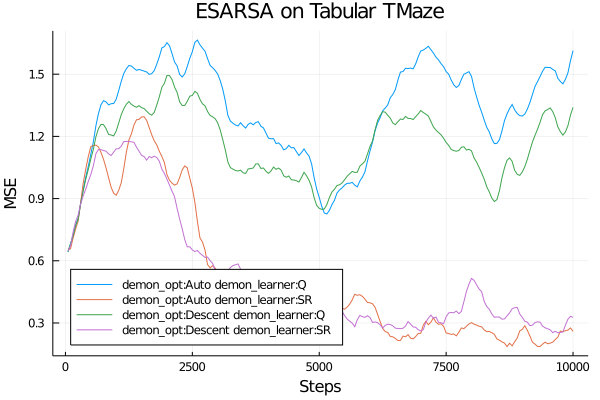

In [468]:
# plot_mc_errors(data, labels,step_increment = 50,data_std=data_std, title="For TB Demon Learners in TMaze Round Robin")
plot_mc_errors(data, labels, step_increment = 50, title="ESARSA on Tabular TMaze")


In [453]:
savefig("./plots/TTMazeUniformESARSA_RMSE.png")

In [450]:
data_per_gvf = [get_stats(load_results(ic,:ttmaze_uniform_error), per_gvf=true)[1] for ic in best_per_algo_ics]

# get_stats(load_results(best_per_algo_ics[2], error_key), per_gvf = true)[1]

# plot_mc_errors(data_per_gvf[3], ["D1", "D2"])

4-element Array{Array{Float64,2},1}:
 [0.5520822204001656 0.5497814444982234 … 0.17484386866692048 0.17749730815245984; 0.5491595551069601 0.5424885178455242 … 0.00017926098881897287 0.00016590007170576453; 0.926323625956116 1.2416974345698044 … 6.613020107494417 6.488003466242558; 0.547875895522213 0.5425308537263549 … 0.0003322136735181437 0.0003214421009501081]
 [0.5536539954213822 0.5505933931763676 … 0.08873338896811223 0.08281738148009561; 0.5495497057485071 0.5470705267647933 … 0.0006751403588986714 0.000671108959866211; 0.9677518680117402 0.996191123255372 … 1.1784674606088497 0.8448578610491886; 0.5513526469299727 0.5459279548006574 … 7.68827457557799e-5 7.647563480804847e-5]
 [0.5503000910170782 0.5458120524248313 … 0.503996569398357 0.5147644288091395; 0.5471273950644627 0.5365717508148056 … 0.0 0.0; 0.9281133908054204 1.2656688563643639 … 5.0896230675755465 4.937582296220635; 0.543861628624682 0.5339593553637961 … 0.0 0.0]
 [0.5536539954213822 0.5523349766050532 … 0.5286370

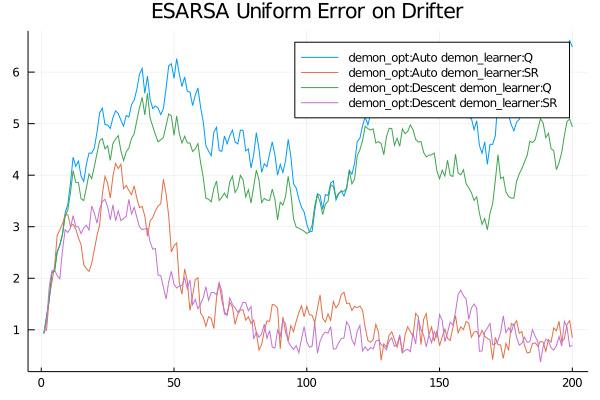

In [452]:
p = plot(title="ESARSA Uniform Error on Drifter")
for (ind,gvf_data) in enumerate(data_per_gvf)
    plot!(p, gvf_data[3,:], label=labels[ind])
end
display(p)
savefig("./plots/TTMazeDrifterESARSA.png")

In [386]:
episode_lengths = [load_results(ic,:episode_length, return_type="array") for ic in best_per_algo_ics]


2-element Array{Array{Any,1},1}:
 [[1362, 98, 96, 224, 111, 173, 473, 294, 854, 88  …  2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 948], [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000  …  2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 1986], [2000, 2000, 8, 2000, 2000, 2000, 2000, 2000, 2000, 2000  …  2000, 2000, 5, 2000, 2000, 2000, 2000, 2000, 2000, 1980], [2000, 2000, 1468, 2000, 2000, 2000, 2000, 2000, 2000, 2000  …  2000, 2000, 2000, 13, 2000, 2000, 2000, 2000, 2000, 496], [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 15, 2000  …  2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 1970], [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000  …  2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 1996], [2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000  …  2000, 5, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 1987], [1378, 119, 105, 111, 83, 101, 201, 112, 196, 95  …  2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 1774], [20

In [387]:
function average_first_n(arr_of_arr,n)
    ave = zeros(n)
    for arr in arr_of_arr
        ave += arr[1:n]
    end
    ave /= length(arr_of_arr)
end

average_first_n (generic function with 1 method)

In [388]:
init_episode_lengths = [average_first_n(episode_lengths[i],50) for i in 1:length(episode_lengths)]

2-element Array{Array{Float64,1},1}:
 [1876.1666666666667, 1647.8, 1508.3333333333333, 1729.2666666666667, 1627.5333333333333, 1686.7, 1744.8333333333333, 1589.8333333333333, 1731.4333333333334, 1743.4666666666667  …  1760.1333333333334, 1804.0, 2000.0, 1800.5333333333333, 1800.8666666666666, 1867.2, 1933.6333333333334, 1867.3333333333333, 1933.7666666666667, 2000.0]
 [1540.9666666666667, 840.1, 497.03333333333336, 286.76666666666665, 296.6333333333333, 247.46666666666667, 200.16666666666666, 216.46666666666667, 172.8, 220.76666666666668  …  104.8, 97.86666666666666, 110.63333333333334, 92.63333333333334, 122.36666666666666, 97.63333333333334, 102.6, 100.96666666666667, 96.5, 101.96666666666667]

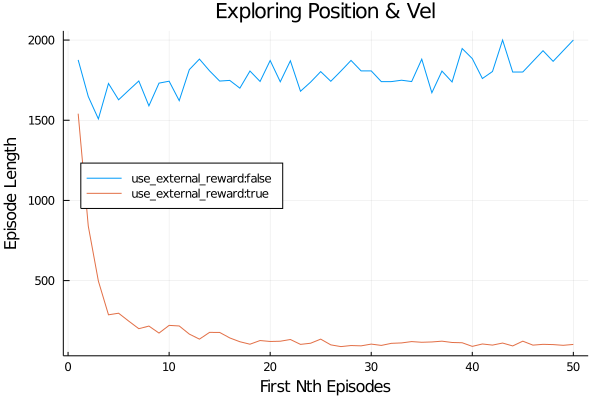

In [389]:
p = plot(ylabel="Episode Length",xlabel="First Nth Episodes", title = "Exploring Position & Vel")
# plot!(p,init_episode_lengths,ylabel="Episode Length",xlabel="First Nth Episodes", title = "Exploring Position")
for (ind,ep_length) in enumerate(init_episode_lengths)
    plot!(p, ep_length, label = labels[ind], legend=:left)
end
display(p)


In [390]:
savefig("./plots/MCEpisodeLengthVel.png")

In [391]:
diff(ic)


Dict{String,Array} with 5 entries:
  "demon_alpha_init"    => [0.015625, 0.03125, 0.0625, 0.125]
  "behaviour_alpha"     => [0.03125, 0.0625]
  "runs"                => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  21, 22, 23, 24, 2…
  "demon_alpha"         => [0.03125, 0.0625, 0.125]
  "use_external_reward" => Bool[0, 1]

In [392]:
function sensitivity(ic,sensitive_param; metric_key=:mc_error)
    param_vals = diff(ic)[sensitive_param]
    vals = zeros(length(param_vals))
    for (i,param_val) in enumerate(param_vals)
        p_ic = search(ic, Dict(sensitive_param => param_val))
#         tmp = load_results(ic, metric_key; return_type = "tensor")
        vals[i] = mean(load_results(p_ic, metric_key; return_type = "tensor"))
    end
    return vals
end


sensitivity (generic function with 1 method)

In [397]:
# search(ic,Dict("demon_alpha_init" => 0.125))
sweep_params = ["use_external_reward", "behaviour_alpha","demon_alpha"]
divisors = split_algo(ic, sweep_params)
sensitivity(ic,"demon_alpha_init")
divisors

["use_external_reward", "behaviour_alpha", "demon_alpha"]


12-element Array{Any,1}:
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"use_external_reward" => false,"demon_alpha" => 0.03125)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"use_external_reward" => false,"demon_alpha" => 0.0625)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"use_external_reward" => false,"demon_alpha" => 0.125)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"use_external_reward" => false,"demon_alpha" => 0.03125)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"use_external_reward" => false,"demon_alpha" => 0.0625)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"use_external_reward" => false,"demon_alpha" => 0.125)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"use_external_reward" => true,"demon_alpha" => 0.03125)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"use_external_reward" => true,"demon_alpha" => 0.0625)
 Dict{Any,Any}("behaviour_alpha" => 0.03125,"use_external_reward" => true,"demon_alpha" => 0.125)
 Dict{Any,Any}("behaviour_alpha" => 0.0625,"use_external_reward" => true,"demon_a

In [419]:
ps = []
for i in 7:12
    y = sensitivity(search(ic,divisors[i]), "demon_alpha_init")
    x = diff(ic)["demon_alpha_init"]
    p = scatter(x,y, ylims=(0.15,0.225), legend=false)
    push!(ps,p)
end
# println(ps)
plot(ps...,layout=(2,3), size = (1000,600))
savefig("./plots/MCSensitivtyExtrinsic")


In [175]:
plot_gvfn_stepsize_sense(ic_gvfn_adam, "end", ylim=(0.0, 0.4))

LoadError: [91mUndefVarError: plot_gvfn_stepsize_sense not defined[39m

In [176]:
ic_rnn = ItemCollection(joinpath(data_home, "compassworld_rnn/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn/data: No such file or directory[39m

In [177]:
0.01*1.5.^(-18:2:1)

10-element Array{Float64,1}:
 6.766394845988643e-6
 1.5224388403474448e-5
 3.425487390781751e-5
 7.707346629258939e-5
 0.00017341529915832613
 0.0003901844231062338
 0.0008779149519890261
 0.0019753086419753087
 0.0044444444444444444
 0.01

In [178]:
diff(ic_rnn_adam)["alpha"]

LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

In [179]:
plot_rnn_stepsize_sens(ic_rnn, 35, "end"; ylims=(0.0,0.3))

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [180]:
plot_rnn_stepsize_sens(ic_rnn, 40, "end"; ylims=(0.0,0.3), legend=false)

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [181]:
plot_rnn_stepsize_sens(ic_rnn, 110, "end"; ylims=(0.0,0.3))

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [182]:
ic_rnn_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn_adam/data: No such file or directory[39m

In [183]:
plot_rnn_stepsize_sens(ic_rnn_adam, 35, "end")

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [184]:
plot_rnn_stepsize_sens(ic_rnn_adam, 40, "end")

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [185]:
plot_rnn_stepsize_sens(ic_rnn_adam, 110, "end")

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

In [186]:
plot_rnn_stepsize_sens(ic_rnn_adam, 5, "end")

LoadError: [91mUndefVarError: plot_rnn_stepsize_sens not defined[39m

## RNN Aux Tasks

In [187]:
ic_rnn_at = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task/data"));
diff(ic_rnn_at)

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn_aux_task/data: No such file or directory[39m

In [188]:
plot_rnn_at_stepsize_sens(ic_rnn_at, "end"; ylims=(0.0, 0.5))

LoadError: [91mUndefVarError: plot_rnn_at_stepsize_sens not defined[39m

In [189]:
plot_rnn_at_stepsize_sens(ic_rnn_at, "all"; ylims=(0.0, 0.5))

LoadError: [91mUndefVarError: plot_rnn_at_stepsize_sens not defined[39m

In [190]:
ic_rnn_at_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task_adam/data"));
diff(ic_rnn_at_adam)

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn_aux_task_adam/data: No such file or directory[39m

In [191]:
plot_rnn_at_stepsize_sens(ic_rnn_at_adam, "end"; ylims=(0.0, 0.5))

LoadError: [91mUndefVarError: plot_rnn_at_stepsize_sens not defined[39m

In [192]:
plot_rnn_at_stepsize_sens(ic_rnn_at_adam, "all"; ylims=(0.0, 0.5))

LoadError: [91mUndefVarError: plot_rnn_at_stepsize_sens not defined[39m

# Final Params

In [193]:
function get_final_gvfn_params(ic, res_key)

    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    sub_ic = ic
    arg_list = Dict{String, Any}[]
    @showprogress for horde ∈ diff(sub_ic)["gvfn-horde"]
        sub_sub_ic = search(sub_ic, Dict("gvfn-horde"=>horde))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, _ = get_best_func(sub_sub_sub_ic)
            push!(arg_list, Dict("gvfn-horde"=>horde, "truncation"=>τ, "alpha"=>prm))
        end

    end
    arg_list
end

function get_final_rnn_params(ic, res_key)

    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    sub_ic = ic
    arg_list = Dict{String, Any}[]
    for cell ∈ diff(sub_ic)["cell"]
        sub_sub_ic = search(sub_ic, Dict("cell"=>cell))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, (μ, σ) = get_best_func(sub_sub_sub_ic)
#             println(μ)
            push!(arg_list, Dict("cell"=>cell, "truncation"=>τ, "alpha"=>prm)) #itm.parsed_args
        end
    end
    arg_list
end

function get_final_rnn_at_params(ic, res_key)

    get_best_func = (i2c)->get_best_setting(i2c, "alpha", (d)->d["results"][res_key])
    sub_ic = ic
    arg_list = Dict{String, Any}[]
    for (horde, cell) ∈ Iterators.product(diff(sub_ic)["at-horde"], diff(sub_ic)["cell"])
        sub_sub_ic = search(sub_ic, Dict("cell"=>cell, "at-horde"=>horde))
        for τ ∈ diff(sub_sub_ic)["truncation"]
            sub_sub_sub_ic = search(sub_sub_ic, Dict("truncation"=>τ))
            prm, (μ, σ) = get_best_func(sub_sub_sub_ic)
#             println(μ)
            push!(arg_list, Dict("cell"=>cell, "at-horde"=>horde, "truncation"=>τ, "alpha"=>prm)) #itm.parsed_args
        end
    end
    arg_list
end


get_final_rnn_at_params (generic function with 1 method)

## GVFN

In [194]:
ic_gvfn = ItemCollection(joinpath(data_home, "compassworld_gvfn/data"));
ic_gvfn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_gvfn_rmsprop/data"));
ic_gvfn_adam = ItemCollection(joinpath(data_home, "compassworld_gvfn_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_gvfn/data: No such file or directory[39m

In [195]:
diff(ic_gvfn)
ic_gvfn.items[1].parsed_args

LoadError: [91mUndefVarError: ic_gvfn not defined[39m

In [196]:
args_list = get_final_gvfn_params(ic_gvfn, "end")
@save "../final_run_params/compassworld/compassworld_gvfn_descent.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn not defined[39m

In [197]:
args_list = get_final_gvfn_params(ic_gvfn_rmsprop, "end")
@save "../final_run_params/compassworld/compassworld_gvfn_rmsprop.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn_rmsprop not defined[39m

In [198]:
args_list = get_final_gvfn_params(ic_gvfn_adam, "end")
@save "../final_run_params/compassworld/compassworld_gvfn_adam.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn_adam not defined[39m

In [199]:
args_list = get_final_gvfn_params(ic_gvfn, "all")
@save "../final_run_params/compassworld/compassworld_gvfn_descent_all.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn not defined[39m

In [200]:
args_list = get_final_gvfn_params(ic_gvfn_rmsprop, "all")
@save "../final_run_params/compassworld/compassworld_gvfn_rmsprop_all.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn_rmsprop not defined[39m

In [201]:
args_list = get_final_gvfn_params(ic_gvfn_adam, "all")
@save "../final_run_params/compassworld/compassworld_gvfn_adam_all.jld2" args_list

LoadError: [91mUndefVarError: ic_gvfn_adam not defined[39m

## RNN

In [202]:
ic_rnn = ItemCollection(joinpath(data_home, "compassworld_rnn/data"));
ic_rnn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_rnn_rmsprop/data"));
ic_rnn_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn/data: No such file or directory[39m

In [203]:
diff(ic_rnn)

LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [204]:
ic_rnn_40 = search(ic_rnn, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_40, "end")
@save "../final_run_params/compassworld/compassworld_rnn_40.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [205]:
ic_rnn_adam_40 = search(ic_rnn_adam, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_adam_40, "end")
@save "../final_run_params/compassworld/compassworld_rnn_adam_40.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

In [206]:
ic_rnn_5 = search(ic_rnn, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_5, "end")
@save "../final_run_params/compassworld/compassworld_rnn_5.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [207]:
ic_rnn_adam_5 = search(ic_rnn_adam, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_adam_5, "end")
@save "../final_run_params/compassworld/compassworld_rnn_adam_5.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

In [208]:
ic_rnn_40 = search(ic_rnn, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_40, "all")
@save "../final_run_params/compassworld/compassworld_rnn_40_all.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [209]:
ic_rnn_adam_40 = search(ic_rnn_adam, Dict("hidden"=>40))
args_list = get_final_rnn_params(ic_rnn_adam_40, "all")
@save "../final_run_params/compassworld/compassworld_rnn_adam_40_all.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

In [210]:
ic_rnn_5 = search(ic_rnn, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_5, "all")
@save "../final_run_params/compassworld/compassworld_rnn_5_all.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn not defined[39m

In [211]:
ic_rnn_adam_5 = search(ic_rnn_adam, Dict("hidden"=>5))
args_list = get_final_rnn_params(ic_rnn_adam_5, "all")
@save "../final_run_params/compassworld/compassworld_rnn_adam_5_all.jld2" args_list


LoadError: [91mUndefVarError: ic_rnn_adam not defined[39m

### AT RNNs

In [212]:
ic_rnn_at = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task/data"));
# ic_rnn_rmsprop = ItemCollection(joinpath(data_home, "compassworld_rnn_rmsprop/data"));
ic_rnn_at_adam = ItemCollection(joinpath(data_home, "compassworld_rnn_aux_task_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_rnn_aux_task/data: No such file or directory[39m

In [213]:
args_list = get_final_rnn_at_params(ic_rnn_at, "end")
@save "../final_run_params/compassworld/compassworld_rnn_aux_task.jld2" args_list

LoadError: [91mUndefVarError: ic_rnn_at not defined[39m

In [214]:
args_list = get_final_rnn_at_params(ic_rnn_at_adam, "end")
@save "../final_run_params/compassworld/compassworld_rnn_aux_task_adam.jld2" args_list

LoadError: [91mUndefVarError: ic_rnn_at_adam not defined[39m

# Forecast Networks

In [215]:
ic_forecast = ItemCollection(joinpath(data_home, "compassworld_forecast/data"));
ic_forecast_rmsprop = ItemCollection(joinpath(data_home, "compassworld_forecast_rmsprop/data"));
ic_forecast_adam = ItemCollection(joinpath(data_home, "compassworld_forecast_adam/data"));

LoadError: [91mSystemError: unable to read directory ../MountainCar/compassworld_forecast/data: No such file or directory[39m

In [216]:
diff(ic_forecast_adam)

LoadError: [91mUndefVarError: ic_forecast_adam not defined[39m

In [217]:
ic_forecast_8 = search(ic_forecast, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_8, "end")
@save "../final_run_params/compassworld/compassworld_forecast_8.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast not defined[39m

In [218]:
ic_forecast_rmsprop_8 = search(ic_forecast_rmsprop, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_rmsprop_8, "end")
@save "../final_run_params/compassworld/compassworld_forecast_rmsprop_8.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast_rmsprop not defined[39m

In [219]:
ic_forecast_adam_8 = search(ic_forecast_adam, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_adam_8, "end")
@save "../final_run_params/compassworld/compassworld_forecast_adam_8.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast_adam not defined[39m

In [220]:
ic_forecast_8 = search(ic_forecast, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_8, "all")
@save "../final_run_params/compassworld/compassworld_forecast_8_all.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast not defined[39m

In [221]:
ic_forecast_rmsprop_8 = search(ic_forecast_rmsprop, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_rmsprop_8, "all")
@save "../final_run_params/compassworld/compassworld_forecast_rmsprop_8_all.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast_rmsprop not defined[39m

In [222]:
ic_forecast_adam_8 = search(ic_forecast_adam, Dict("klength"=>8))
args_list = get_final_rnn_params(ic_forecast_adam_8, "all")
@save "../final_run_params/compassworld/compassworld_forecast_adam_8_all.jld2" args_list

LoadError: [91mUndefVarError: ic_forecast_adam not defined[39m